# Libraries

In [673]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn import metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

In [705]:
%run Data_preprocessing.ipynb

************************************************************
There are 3 set of X
X_train_mean, X_valid_mean, X_test_mean
------------------------------------------------------------
Normalized version
X_train_norm, X_valid_norm, X_test_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
************************************************************


In [707]:
print(X_train_norm.shape)
print(X_valid_norm.shape)
print(X_test_norm.shape)

(16760, 61)
(2394, 61)
(4790, 61)


# Imbalanced Learning

In [708]:
Full = pd.DataFrame(np.concatenate((X_train_norm,pd.DataFrame(y_train_t1.iloc[:,-1])),axis=1))
Full

label0 = Full[Full[61]==0]
label1 = Full[Full[61]==1]
print(label0.shape,label1.shape)

(15535, 62) (1225, 62)


In [709]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(X_train_norm, y_train_t1.iloc[:,-1])


y_over = pd.DataFrame(y_over)
y_over.shape
x_over.shape

(31070, 61)

In [710]:
Full = pd.DataFrame(np.concatenate((x_over,y_over),axis=1))
Full

label0 = Full[Full[61]==0]
label1 = Full[Full[61]==1]
print(label0.shape,label1.shape)

(15535, 62) (15535, 62)


In [682]:
X_train_norm=x_over

y_train_t1 = y_over

# Hyperparameters

In [683]:
input_size = X_train_norm.shape[1] # 7488/24
output_size = 2 # live or dead
learning_rate = 0.01
batch_size = 64
num_epochs = 200

# Create FullyNet

In [684]:
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 52)
        self.fc2 = nn.Linear(52, 26)
        self.fc3 = nn.Linear(26, 13)
        self.fc4 = nn.Linear(13, 1)
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(52)
        self.batchnorm2 = nn.BatchNorm1d(26)

        
        
    def forward(self, x):
         x = F.leaky_relu(self.fc1(x))
         x = self.batchnorm1(x)
         x = F.leaky_relu(self.fc2(x))
         x = self.batchnorm2(x)
         x = F.leaky_relu(self.fc3(x))
         x = self.dropout(x)
         x = torch.sigmoid(self.fc4(x))
         return x

# Data transform

In [685]:
class CusDatasetLoader(Dataset):
    def __init__(self,x,y):
        self.len = y.shape[0]
        self.x_data = x
        self.y_data = y
  
    def __len__(self):
        return self.len

    def __getitem__(self, index):
        #return self.dataframe.iloc[index]
        return self.x_data[index], self.y_data[index]

In [686]:
# X_shape(X) : used for split the data into a right tensor size
#input: X in shape of 16760 rows × 104 columns (df)
#output: X in shape of torch.Size([16760, 104, 1]) (tensor)

def X_tensor(X):
    X_tensor = torch.from_numpy(np.array(X)).to(torch.float32)
    #print(X_tensor.shape)
    #X_tensor = torch.stack(X_tensor).permute()
    print("X now in shape of",X_tensor.shape)
    return X_tensor

# y_tensor(y) : used for split the data into a right tensor size
#input: X in shape of 16760 rows × 7488 columns (df)
#output: X in shape of torch.Size([16760, 312, 24]) (tensor)

def y_tensor(y):
    y= torch.from_numpy(np.array(y)).to(torch.float32).reshape(len(y),1)
    print("y now in shape of",y.shape)
    return y

In [687]:
# X should be in smaples, 1, squence, rows
X1 = X_tensor(X_train_norm)
y1 = y_tensor(y_train_t1.iloc[:,-1].astype(float))

train_datasets = CusDatasetLoader(X1, y1)
train_loader = DataLoader(dataset=train_datasets, batch_size=batch_size, shuffle=True)

x,y = train_datasets[0]
print(x.shape)
print(y.shape)

X now in shape of torch.Size([2450, 61])
y now in shape of torch.Size([2450, 1])
torch.Size([61])
torch.Size([1])


# Model train

In [688]:
model = NN(input_size).to(device)

In [689]:
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer = optim.Adadelta(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [690]:
losses=[]
acc_list=[]

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        num_correct = 0
        num_samples = 0
        data = data.to(device=device)
        targets = targets.to(device=device)
        #targets = torch.squeeze(targets, 1).type(torch.LongTensor)
        
        # forward
        scores = model(data)
        #print(scores)
        loss = criterion(scores, targets)
        
        l2_lambda = 0.02
        l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())
 
        loss = loss + l2_lambda * l2_norm
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        
        # gradient descent or adam step
        optimizer.step()
        
        #accuracy
        scores = model(data)
        predictions = scores
        predictions = predictions.detach().apply_( lambda x: 1 if x >= 0.5 else 0 )
        num_correct += int((predictions == targets).sum())
        num_samples += predictions.size(0)
        acc = num_correct / num_samples
        
    if epoch%5 == 0:
        losses.append(loss.detach().numpy() )
        acc_list.append(acc)
    print(f'Epoch {epoch:03}: | Loss: {loss:.5f} | Acc: {acc:.3f}')
        
        

Epoch 000: | Loss: 2.33974 | Acc: 0.444
Epoch 001: | Loss: 2.40086 | Acc: 0.556
Epoch 002: | Loss: 2.19743 | Acc: 0.222
Epoch 003: | Loss: 2.25953 | Acc: 0.389
Epoch 004: | Loss: 2.21532 | Acc: 0.278
Epoch 005: | Loss: 2.19348 | Acc: 0.333
Epoch 006: | Loss: 2.22622 | Acc: 0.444
Epoch 007: | Loss: 2.33868 | Acc: 0.722
Epoch 008: | Loss: 2.29225 | Acc: 0.667
Epoch 009: | Loss: 2.14053 | Acc: 0.389
Epoch 010: | Loss: 2.17375 | Acc: 0.500
Epoch 011: | Loss: 2.23254 | Acc: 0.667
Epoch 012: | Loss: 2.13462 | Acc: 0.500
Epoch 013: | Loss: 2.14215 | Acc: 0.556
Epoch 014: | Loss: 2.07066 | Acc: 0.444
Epoch 015: | Loss: 1.99866 | Acc: 0.333
Epoch 016: | Loss: 2.00700 | Acc: 0.389
Epoch 017: | Loss: 2.04105 | Acc: 0.500
Epoch 018: | Loss: 2.12621 | Acc: 0.722
Epoch 019: | Loss: 1.95294 | Acc: 0.389
Epoch 020: | Loss: 2.03881 | Acc: 0.611
Epoch 021: | Loss: 2.02135 | Acc: 0.611
Epoch 022: | Loss: 1.92640 | Acc: 0.444
Epoch 023: | Loss: 1.93471 | Acc: 0.500
Epoch 024: | Loss: 1.96963 | Acc: 0.611


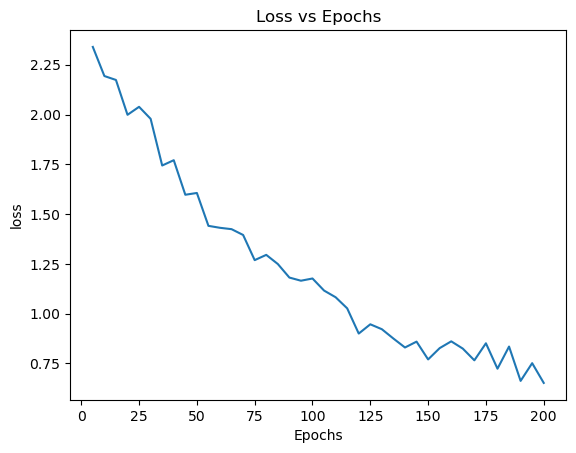

In [701]:
#plotting the loss
x_range = list(range(5,5*len(losses)+5,5))
plt.plot(x_range,losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

# Model Accuracy

In [692]:
num_correct = 0
num_samples = 0

# Set model to eval
model.eval()

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y.to(device=device)
        #y = torch.squeeze(y.to(device=device), 1)
        #print(y.shape)

        scores = model(x)
        predictions = scores
        predictions = predictions.apply_( lambda x: 1 if x >= 0.5 else 0 )
        num_correct += int((predictions == y).sum())
        num_samples += predictions.size(0)

# Toggle model back to train
model.train()
#print(num_correct , num_samples)
num_correct / num_samples

0.5

In [693]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in train_loader:
            x = x.to(device=device)
            y.to(device=device)
            #y = torch.squeeze(y.to(device=device), 1)
            #print(y.shape)

            scores = model(x)
            predictions = scores
            predictions = predictions.apply_( lambda x: 1 if x >= 0.5 else 0 )
            num_correct += int((predictions == y).sum())
            num_samples += predictions.size(0)

    # Toggle model back to train
    model.train()
    return num_correct / num_samples

In [694]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:2f} %")
#print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f} %")

Accuracy on training set: 50.000000 %


In [695]:
X2 = X_tensor(X_valid_norm)
y2 = y_tensor(y_valid_t1.iloc[:,-1])

Valid_datasets = CusDatasetLoader(X2, y2)
Valid_loader = DataLoader(dataset=Valid_datasets, batch_size=batch_size, shuffle=True)
print(f"Accuracy on valid set: {check_accuracy(Valid_loader, model)*100:.2f} %")

X now in shape of torch.Size([2394, 61])
y now in shape of torch.Size([2394, 1])
Accuracy on valid set: 50.00 %


(2394, 1)
(2394, 1)


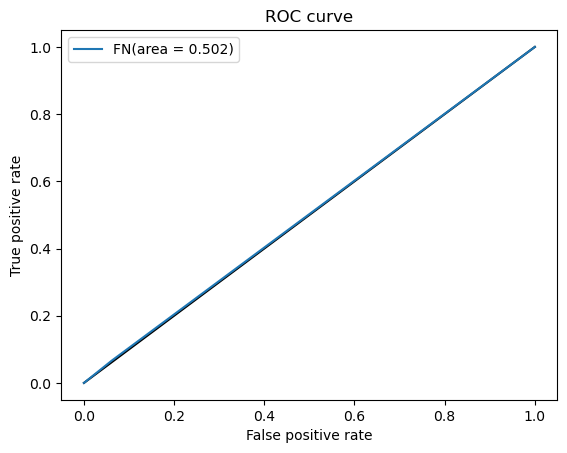

In [696]:
y_true = np.array(y_valid_t1.iloc[:,[-1]])
all_y_pred = []

model.eval()
with torch.no_grad():
    for x, y in Valid_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            #y = torch.squeeze(y.to(device=device), 1)
            
            pred_y1 = torch.sigmoid(model(x))
            y_pred = pred_y1.squeeze(-1).detach().numpy()
            all_y_pred = np.append(all_y_pred, y_pred)

print(y_true.shape)
print(all_y_pred.reshape(-1,1).shape)
fpr, tpr, _ = metrics.roc_curve(y_true, all_y_pred)
roc_auc = metrics.roc_auc_score(y_true, all_y_pred)

model.train()

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='FN(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve")
plt.legend(loc="best")
plt.show()

# Test

In [697]:
def test(loader, model):
    # Set model to eval
    model.eval()
    res = torch.tensor([], dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y.to(device=device)

            scores = model(x)
            predictions = scores
            res =  torch.cat((predictions, res), 0)  
    model.train()
   
    return res

In [698]:
X_test_mean
x_valid_mean=X_test_mean.values
x_valid_mean_scaled = scaler.fit_transform(x_valid_mean)
X_test_norm=pd.DataFrame(x_valid_mean_scaled)
X_test_norm

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.165740,-0.004162,0.073994,0.185472,0.127482,-0.006190,0.972110,0.088822,-0.701075,-0.080230,...,-1.253352,0.761817,-0.268789,0.796971,-2.789214,3.176095,-0.553177,0.027071,-0.017092,0.765229
1,-0.504386,1.730745,-0.183348,-1.315022,-0.430294,-0.371828,1.212867,-0.484192,-0.344128,-0.010144,...,0.154415,0.298574,-0.174854,0.058073,0.041105,0.019050,-0.022098,0.027071,-0.143602,2.209077
2,-0.477027,1.012991,0.291617,0.185472,-0.442176,-0.789188,0.731352,-0.657678,-0.548098,0.410367,...,0.154415,-0.164669,1.187213,-1.225180,0.041105,0.019050,-0.022098,0.027071,-0.636430,-0.528219
3,0.165740,-0.004162,0.073994,-0.714824,0.127482,-0.006190,-0.231679,0.088822,0.012818,-0.028788,...,-2.901256,-0.396290,-0.409693,1.419130,1.121996,1.089125,0.097808,0.027071,0.246553,-0.633499
4,-0.529010,-0.004162,-0.247532,-0.714824,-0.447268,2.549697,-0.231679,-0.657678,-0.344128,-0.781082,...,0.154415,0.298574,-1.583888,1.185786,0.041105,0.019050,-0.022098,0.027071,-0.017092,-1.550945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,0.165740,-0.004162,0.073994,-0.414726,0.127482,-0.006190,1.453625,0.088822,0.012818,0.550538,...,-3.999859,-0.396290,-1.255113,-0.214115,-0.791603,-5.693526,-0.137387,0.027071,-1.083055,-0.347738
4786,0.165740,-0.004162,0.073994,0.485571,0.127482,-0.006190,-1.194710,0.088822,2.103507,0.340282,...,0.154415,-2.017639,0.952374,-0.602983,0.041105,0.019050,-0.022098,-0.655784,-0.460709,0.028265
4787,0.165740,-0.004162,0.073994,-0.414726,0.127482,-0.006190,-0.713195,0.088822,-0.752067,-0.028788,...,0.119901,-0.396290,-0.315757,0.719168,-0.866280,0.045641,-0.137387,0.027071,0.415963,-0.257497
4788,0.165740,-0.004162,0.073994,1.085769,0.127482,-1.206549,-0.231679,0.088822,0.471750,0.270197,...,0.154415,0.530195,1.140245,-0.914077,0.041105,0.019050,-0.022098,-0.593120,-0.636430,1.096111


In [699]:
X_test_final = X_tensor(X_test_norm)
y_final = torch.zeros([4790,1])

test_datasets = CusDatasetLoader(X_test_final, y_final)
test_loader = DataLoader(dataset=test_datasets, batch_size=batch_size, shuffle=True)

result = test(test_loader, model)
result

X now in shape of torch.Size([4790, 61])


tensor([[0.4238],
        [0.4238],
        [0.4238],
        ...,
        [0.4238],
        [0.4238],
        [0.4238]])

In [700]:

#df.index = ['Row_1', 'Row_2', 'Row_3', 'Row_4']
res1 = pd.DataFrame(result.tolist(), columns=["Predicted"])
res1.index = X_test.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('out.csv')
#print(torch.count_nonzero(torch.from_numpy(np.array(res1)).to(torch.float32)))
res1

,Predicted
Id,
32_175413_295037,0.423837
33_176176_296681,0.423837
42_119203_210828,0.423837
44_181750_291554,0.423837
61_176332_252348,0.423837
...,...
99883_150755_276467,0.423837
99897_162913_266801,0.423837
99913_175989_292375,0.423837


#

#

#